<a href="https://colab.research.google.com/github/FarhadKhankishiyev068/Thesis/blob/main/Thesis_2023068.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*DATASET address: https://www.kaggle.com/datasets/biancaferreira/african-wildlife

In [1]:
# Installing necessary library
!pip install lime

# Importing necessary libraries for my project
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
import lime
import lime.lime_image
from skimage.segmentation import mark_boundaries
import tensorflow as tf

# Setting random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Dpath of my dataset
data_dir = '/content/drive/My Drive/animals'  # Data set from my google drive
classes = ['zebra', 'buffalo', 'elephant', 'rhino']

# Structure of the dataset
for cls in classes:
    class_dir = os.path.join(data_dir, cls)
    print(f"{cls} contains {len(os.listdir(class_dir))} images")


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283835 sha256=7fa7e447ca4e340d8fb83af7007f11c4083178278061f16d9d60af17337e2867
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime
zebra contains 752 images
buffalo contains 752 images
elephant contains 752 images
rhino contains 752 images


## Data Preprocessing
In this section, I will load the dataset, perform data augmentation, and split it into training and validation sets.
Data augmentation is crucial for improving the robustness of the model by artificially increasing the diversity of the training data.


In [2]:
def create_generators(data_dir, target_size=(32, 32), batch_size=32, validation_split=0.2):
    """
    Create training and validation data generators with data augmentation.
    """
    datagen = ImageDataGenerator(
        rescale=1./255,          # Normalizing the pixel values to [0, 1]
        shear_range=0.2,         # Applying shear transformations
        zoom_range=0.2,          # Applying zoom transformations
        horizontal_flip=True,    # Applying horizontal flip
        validation_split=validation_split)  # Using specified percentage of data for validation

    train_gen = datagen.flow_from_directory(
        data_dir,
        target_size=target_size,   # Resizing images to target size
        batch_size=batch_size,
        class_mode='categorical',
        subset='training')         # Settin as training data

    val_gen = datagen.flow_from_directory(
        data_dir,
        target_size=target_size,   # Resizing images to target size
        batch_size=batch_size,
        class_mode='categorical',
        subset='validation')       # Setting as validation data

    return train_gen, val_gen

# Creating training and validation generators
train_generator, validation_generator = create_generators(data_dir)


Found 1204 images belonging to 4 classes.
Found 300 images belonging to 4 classes.


## Model Training
I will define and train a simple Softmax Regression model using Keras.
Softmax Regression is a generalization of logistic regression to multiple classes.


In [15]:
def build_and_train_model(train_gen, val_gen, epochs=200):
    """
    Build and train the Softmax Regression model.
    """
    model = Sequential([
        Flatten(input_shape=(32, 32, 3)),  # Flattening the input images
        Dense(4, activation='softmax')     # Output layer with 4 neurons (one for each class) and softmax activation
    ])

    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=epochs  # Training for the specified number of epochs
    )

    return model, history

# Building and training the model
softmax_model, softmax_history = build_and_train_model(train_generator, validation_generator)

# Evaluating the model
scores = softmax_model.evaluate(validation_generator)
print(f"Validation Accuracy: {scores[1]*100:.2f}%")


Epoch 1/200
38/38 [==============================] - 29s 738ms/step - loss: 1.3693 - accuracy: 0.3555 - val_loss: 1.3108 - val_accuracy: 0.3600
Epoch 2/200
38/38 [==============================] - 25s 657ms/step - loss: 1.2282 - accuracy: 0.4468 - val_loss: 1.2308 - val_accuracy: 0.4400
Epoch 3/200
38/38 [==============================] - 23s 606ms/step - loss: 1.1777 - accuracy: 0.4958 - val_loss: 1.2551 - val_accuracy: 0.4200
Epoch 4/200
38/38 [==============================] - 41s 1s/step - loss: 1.2515 - accuracy: 0.4543 - val_loss: 1.4895 - val_accuracy: 0.3367
Epoch 5/200
38/38 [==============================] - 23s 620ms/step - loss: 1.2208 - accuracy: 0.4693 - val_loss: 1.4518 - val_accuracy: 0.4000
Epoch 6/200
38/38 [==============================] - 26s 682ms/step - loss: 1.2024 - accuracy: 0.4784 - val_loss: 1.1794 - val_accuracy: 0.4667
Epoch 7/200
38/38 [==============================] - 24s 649ms/step - loss: 1.1581 - accuracy: 0.4925 - val_loss: 1.2560 - val_accuracy: 0.

## Model Evaluation
After training the model, I will evaluate its performance using accuracy and loss plots.
This helps in understanding how well the model is performing on training and validation data over epochs.


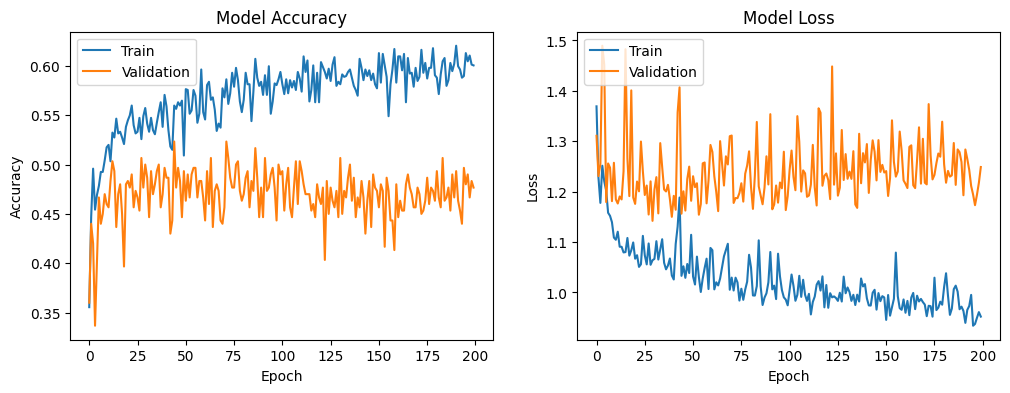

In [16]:
def plot_metrics(history):
    """
    Plot training and validation accuracy and loss.
    """
    plt.figure(figsize=(12, 4))

    # Plotting Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plotting Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.show()

# Plot metrics
plot_metrics(softmax_history)


## Confusion Matrix and Classification Report
To gain deeper insights into the model's performance, I will analyze the confusion matrix and generate a classification report.
The confusion matrix will show the number of correct and incorrect predictions for each class, and the classification report will provide precision, recall, and F1-score for each class.


10/10 [==============================] - 4s 354ms/step


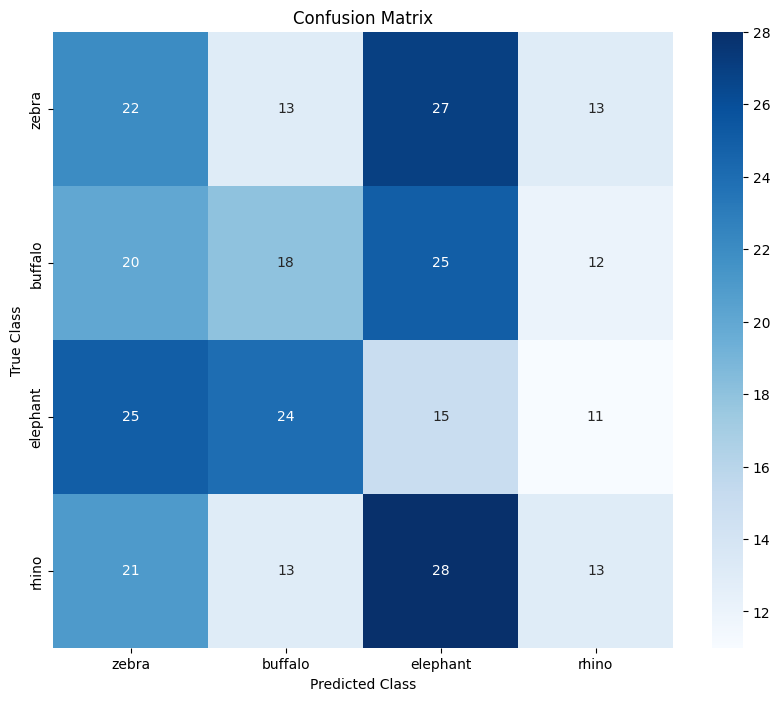

              precision    recall  f1-score   support

       zebra       0.25      0.29      0.27        75
     buffalo       0.26      0.24      0.25        75
    elephant       0.16      0.20      0.18        75
       rhino       0.27      0.17      0.21        75

    accuracy                           0.23       300
   macro avg       0.23      0.23      0.23       300
weighted avg       0.23      0.23      0.23       300



In [5]:
def evaluate_model(model, val_gen, classes):
    """
    Evaluate the model using confusion matrix and classification report.
    """
    y_pred = model.predict(val_gen)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = val_gen.classes

    # Generating Confusion Matrix
    conf_matrix = confusion_matrix(y_true, y_pred_classes)
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Class')
    plt.ylabel('True Class')
    plt.show()

    # Generating Classification Report
    class_report = classification_report(y_true, y_pred_classes, target_names=classes)
    print(class_report)

# Evaluating the model
evaluate_model(softmax_model, validation_generator, classes)


## Predictions with Confidence Levels
This section includes the function to predict the class of an image along with the confidence levels.


1/1 [==============================] - 0s 80ms/step
Predicted Class: zebra
Confidence: 0.94


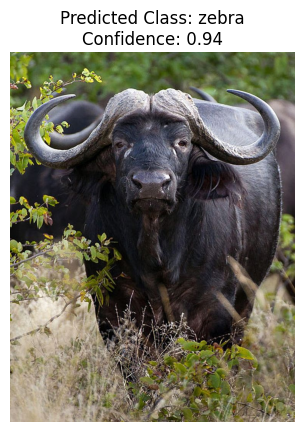

In [6]:
def predict_image_class(img_path, model, class_labels):
    """
    Predict the class of an image using the trained model and display the confidence level.
    """
    img = load_img(img_path, target_size=(32, 32))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array.astype(np.float32) / 255.0

    # Predicting class probabilities
    class_probabilities = model.predict(img_array)
    predicted_class_index = np.argmax(class_probabilities)

    # Checking if the predicted_class_index is in class_labels
    if predicted_class_index in class_labels:
        predicted_class_label = class_labels[predicted_class_index]
        confidence = class_probabilities[0][predicted_class_index]

        # Printing predicted class and confidence
        print(f"Predicted Class: {predicted_class_label}")
        print(f"Confidence: {confidence:.2f}")

        # Displaying the image with predicted class and confidence as title
        plt.imshow(load_img(img_path))
        plt.axis('off')
        plt.title(f"Predicted Class: {predicted_class_label}\nConfidence: {confidence:.2f}")
        plt.show()
    else:
        print(f"Predicted class index {predicted_class_index} not found in class_labels.")

# Example prediction
sample_img_path = '/content/drive/My Drive/animals/buffalo/067.jpg'  # Update with an actual image path
class_labels = {0: 'zebra', 1: 'buffalo', 2: 'elephant', 3: 'rhino'}
predict_image_class(sample_img_path, softmax_model, class_labels)


## LIME Explanations
Despite achieving high accuracy, the model sometimes misclassifies images.
To understand why these misclassifications occur, I will use LIME (Local Interpretable Model-agnostic Explanations) to generate explanations for the model's predictions.
LIME helps in interpreting complex models by approximating them locally with interpretable models.


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 24ms/step


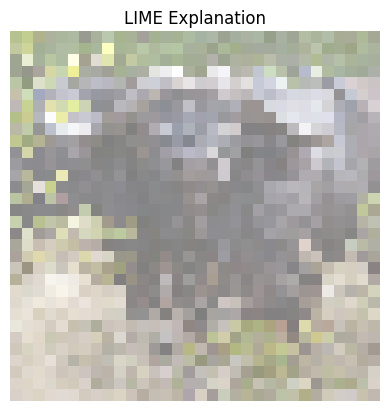

In [7]:
def generate_lime_explanation(img_path, model, num_samples=1000, top_labels=4):
    """
    Generate explanations using LIME for the given image.
    """
    # Loading and preprocess the image
    img = load_img(img_path, target_size=(32, 32))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array.astype(np.float32) / 255.0

    # Creating LIME explainer
    explainer = lime.lime_image.LimeImageExplainer()

    # Generating explanations
    explanation = explainer.explain_instance(img_array[0], model.predict, top_labels=top_labels, hide_color=0, num_samples=num_samples)

    # ting the explanation mask
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)

    # Overlay of the mask onto the original image
    overlay = mark_boundaries(temp / 2 + 0.5, mask)

    # Displaying the overlay image
    plt.imshow(overlay)
    plt.title('LIME Explanation')
    plt.axis('off')
    plt.show()

# Example path to the misclassified images
misclassified_images = ['/content/drive/My Drive/animals/buffalo/067.jpg']  # Misclassified images from dataset

# Generating explanations for misclassified images
for img_file in misclassified_images:
    generate_lime_explanation(img_file, softmax_model)


In [8]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam

def build_cnn_model():
    """
    Build a CNN model using transfer learning with VGG16.
    """
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
    x = base_model.output
    x = Flatten()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(4, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)

    # Freeze the base model layers
    for layer in base_model.layers:
        layer.trainable = False

    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Building and training the CNN model
cnn_model = build_cnn_model()
cnn_history = cnn_model.fit(train_generator, validation_data=validation_generator, epochs=55)

# Evaluating the CNN model


58889256/58889256 [==============================] - 0s 0us/step
Epoch 1/55
38/38 [==============================] - 45s 1s/step - loss: 1.2343 - accuracy: 0.4444 - val_loss: 1.0491 - val_accuracy: 0.5567
Epoch 2/55
38/38 [==============================] - 44s 1s/step - loss: 1.0459 - accuracy: 0.5415 - val_loss: 1.0211 - val_accuracy: 0.5567
Epoch 3/55
38/38 [==============================] - 41s 1s/step - loss: 0.9498 - accuracy: 0.5922 - val_loss: 1.0653 - val_accuracy: 0.5300
Epoch 4/55
38/38 [==============================] - 41s 1s/step - loss: 0.9377 - accuracy: 0.6105 - val_loss: 1.1183 - val_accuracy: 0.5367
Epoch 5/55
38/38 [==============================] - 40s 1s/step - loss: 0.8833 - accuracy: 0.6262 - val_loss: 1.0567 - val_accuracy: 0.5600
Epoch 6/55
38/38 [==============================] - 36s 942ms/step - loss: 0.8516 - accuracy: 0.6478 - val_loss: 1.0511 - val_accuracy: 0.5400
Epoch 7/55
38/38 [==============================] - 43s 1s/step - loss: 0.8246 - accuracy: 0

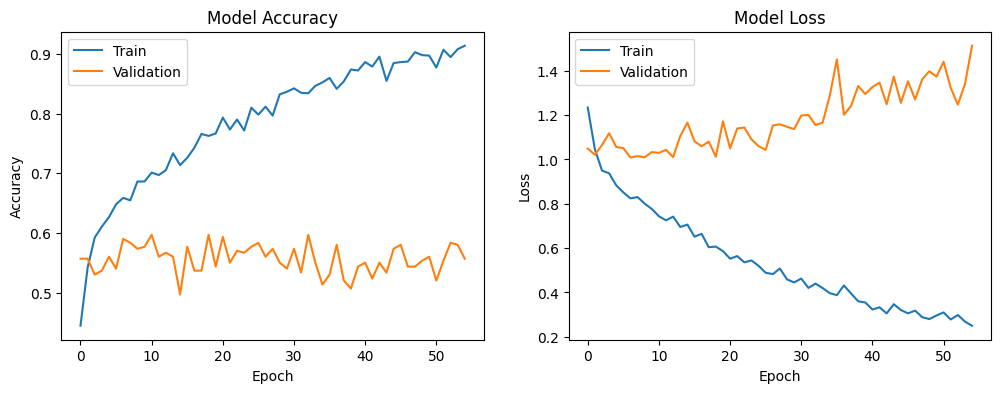

10/10 [==============================] - 6s 594ms/step


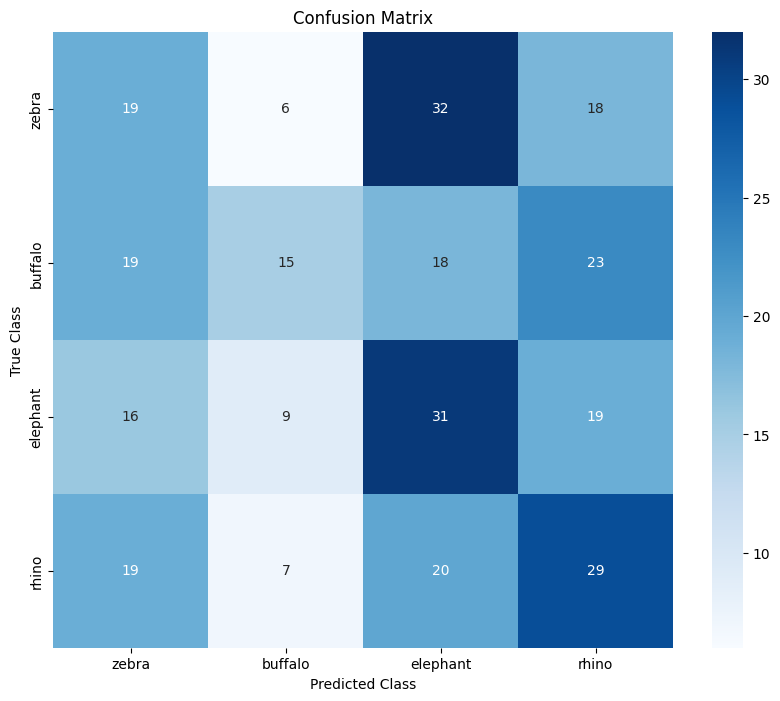

              precision    recall  f1-score   support

       zebra       0.26      0.25      0.26        75
     buffalo       0.41      0.20      0.27        75
    elephant       0.31      0.41      0.35        75
       rhino       0.33      0.39      0.35        75

    accuracy                           0.31       300
   macro avg       0.32      0.31      0.31       300
weighted avg       0.32      0.31      0.31       300



In [9]:
# Plot metrics for CNN model
plot_metrics(cnn_history)

# Evaluating the CNN model
evaluate_model(cnn_model, validation_generator, classes)



In [17]:
# Evaluating the Softmax Regression Model
softmax_scores = softmax_model.evaluate(validation_generator)
softmax_model_accuracy = softmax_scores[1] * 100

# Evaluating the CNN model
cnn_scores = cnn_model.evaluate(validation_generator)
cnn_model_accuracy = cnn_scores[1] * 100

print(f"Softmax Regression Model Validation Accuracy: {softmax_model_accuracy:.2f}%")
print(f"CNN Model Validation Accuracy: {cnn_model_accuracy:.2f}%")


10/10 [==============================] - 6s 615ms/step - loss: 1.3981 - accuracy: 0.5667
Softmax Regression Model Validation Accuracy: 44.33%
CNN Model Validation Accuracy: 56.67%


Softmax Regression Model Misclassifications:
10/10 [==============================] - 4s 401ms/step
Misclassified Image: /content/drive/My Drive/animals/buffalo/010.jpg


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


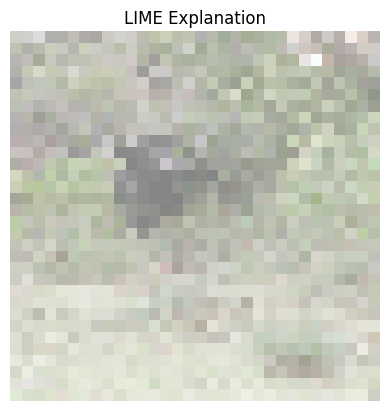

Misclassified Image: /content/drive/My Drive/animals/zebra/009.jpg


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 21ms/step


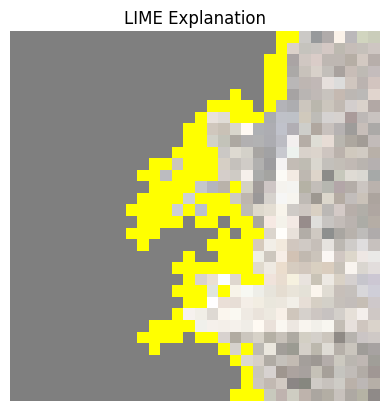

Misclassified Image: /content/drive/My Drive/animals/zebra/006.jpg


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


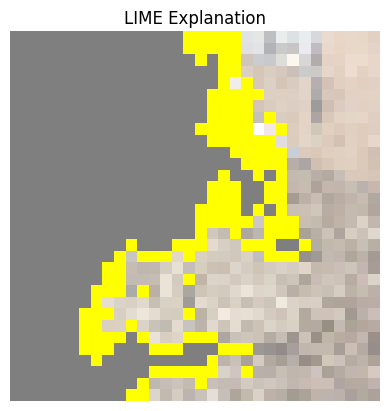

CNN Model Misclassifications:
10/10 [==============================] - 13s 1s/step
Misclassified Image: /content/drive/My Drive/animals/buffalo/007.jpg


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 124ms/step


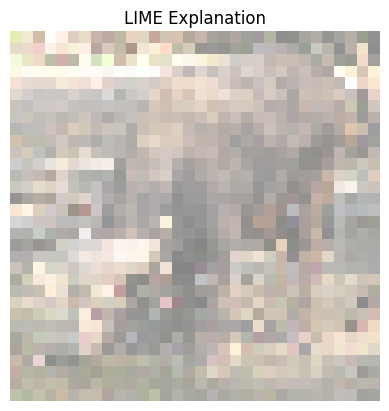

Misclassified Image: /content/drive/My Drive/animals/elephant/004.jpg


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 213ms/step


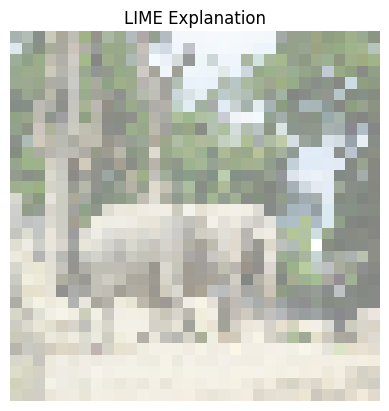

Misclassified Image: /content/drive/My Drive/animals/elephant/075.jpg


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 128ms/step


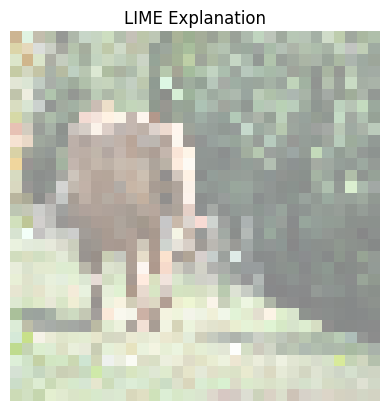

In [11]:
import random

def detailed_error_analysis(model, val_gen, classes, num_samples=3):
    """
    Perform detailed error analysis to identify common misclassification patterns.
    """
    y_pred = model.predict(val_gen)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = val_gen.classes

    misclassified_indices = np.where(y_pred_classes != y_true)[0]
    if len(misclassified_indices) > num_samples:
        misclassified_indices = random.sample(list(misclassified_indices), num_samples)

    for idx in misclassified_indices:
        img_path = val_gen.filepaths[idx]
        print(f"Misclassified Image: {img_path}")
        generate_lime_explanation(img_path, model)

# Performing detailed error analysis on the Softmax Regression Model
print("Softmax Regression Model Misclassifications:")
detailed_error_analysis(softmax_model, validation_generator, classes)

# Performing detailed error analysis on the CNN model
print("CNN Model Misclassifications:")
detailed_error_analysis(cnn_model, validation_generator, classes)


Loading image from path: /content/drive/My Drive/animals/elephant/019.jpg
Image loaded and preprocessed.
LIME explainer created.


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 129ms/step
Explanation generated.
Explanation mask obtained.
Overlay created.


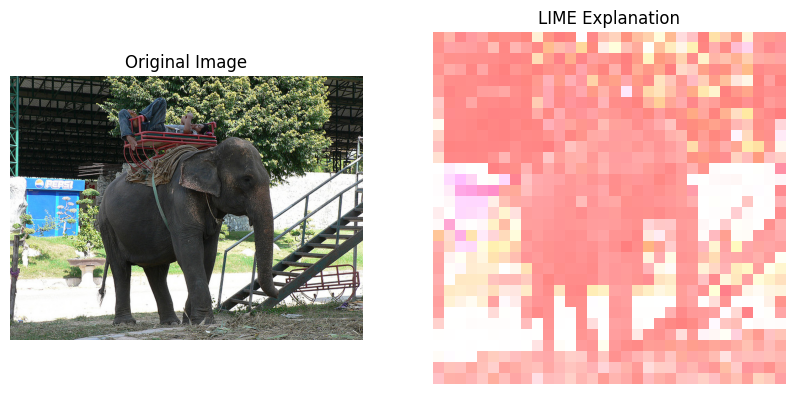

LIME explanation displayed.


In [14]:
from lime import lime_image

def generate_lime_explanation(img_path, model, num_samples=1000, top_labels=4):
    """
    Generate explanations using LIME for the given image.
    """
    try:
        # Checking if the image path exists
        if not os.path.exists(img_path):
            print(f"Error: Image path '{img_path}' does not exist.")
            return

        # Loading and preprocessing the image
        print(f"Loading image from path: {img_path}")
        img = load_img(img_path, target_size=(32, 32))
        img_array = img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = img_array.astype(np.float32) / 255.0
        print("Image loaded and preprocessed.")

        # Creating LIME explainer
        explainer = lime_image.LimeImageExplainer()
        print("LIME explainer created.")

        # Generating explanations
        explanation = explainer.explain_instance(img_array[0], model.predict, top_labels=top_labels, hide_color=0, num_samples=num_samples)
        print("Explanation generated.")

        # Getting the explanation mask
        temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=5, hide_rest=False)
        print("Explanation mask obtained.")

        # Overlaying the mask onto the original image
        overlay = mark_boundaries(temp / 2 + 0.5, mask)
        print("Overlay created.")

        # Displaying the original image and the overlay image
        fig, ax = plt.subplots(1, 2, figsize=(10, 5))
        ax[0].imshow(load_img(img_path))
        ax[0].axis('off')
        ax[0].set_title('Original Image')

        ax[1].imshow(overlay)
        ax[1].axis('off')
        ax[1].set_title('LIME Explanation')

        plt.show()
        print("LIME explanation displayed.")
    except Exception as e:
        print(f"An error occurred: {e}")

# Example usage
sample_img_path = '/content/drive/My Drive/animals/elephant/019.jpg'  # valid images from dataset
generate_lime_explanation(sample_img_path, softmax_model)  # or cnn_model
